# Lab 6

**Due:** Monday, December 4 5PM EST.

**Instructions:** Please submit your files to the Dropbox link posted on Cavnas. Remember to rename the notebook by filling in your uniqname. If you have _additional_ supplementary files (e.g., images), please also attach them in your submission.

**Collaboration policy:** You may discuss high level ideas with others but specific answers need to be your own. Please indicate with whom you exchanged any ideas.

## Problem 1: Clique Percolation Method (CPM)

### Part a) apply clustering

Consider the following graph. Apply CPM with k=3 and identify the communities accordingly. Please do this by hand and show your work process.



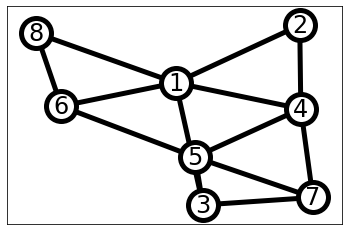

![alt text](cpm_1.png)
![alt text](cpm_2.png)

### Part b) compare with groundtruth data

Imagine you learned that there are three real communities:  
C1 = {1,2,3,4}   
C2 = {5,6,8}  
C3 = {7}  

Calculate the accuracy (using accuracy of pairwise community memberships) of the CPM solution you computed above.  
Please do this by hand and show your work process.

![alt text](accuracy.png)

## Problem 2: Betweenness Clustering

In an earlier lab you practiced using `girvan_newman()` to perform betweenness clustering. In this part you'll build the function from scratch to understand how it actually operates. Let's use a random ER graph with parameters: `n = 100`, `p = 0.05`, `seed = 2666` (so the results are reproducible).
    
Please read through the comment and return the exact output as required.
    
### Part a) build the function

In [1]:
import networkx as nx
import pandas as pd

In [2]:
# 0. generate an ER graph

# YOUR CODE HERE
g = nx.erdos_renyi_graph(n = 100, p = 0.05, seed = 2666)

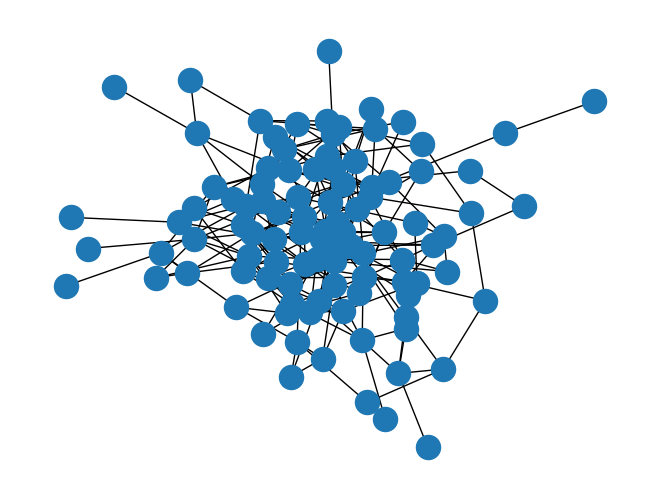

In [3]:
nx.draw(g)

In [4]:
# 1. define a function that returns the most valuable edge in a graph (with the highest betweenness)
# - one input, g --> a networkx graph object
# - one output, the most valuable edge; should be a tuple, e.g., (node1, node2)

def fetch_most_valuable_edge(g):
    betweeness = nx.edge_betweenness_centrality(g)
    edges = sorted(list(betweeness.keys()), key = lambda s: betweeness[s], reverse = True)
    return edges[0]

In [5]:
# 2. define a function that performs one round of betweenness clustering every time you call it
# - two inputs: g and the fetch_edge function (you defined in the last cell)
# - one output: a sorted community list (sorted by community size, descending)
# ---- community list is a list of communities detected, each community itself is a list of nodes
# ---- e.g., for two communities (node a, node b), (node c, node d, node e),
# ---- the output should look like this: [[c,d,e], [a,b]]

def perform_betw_clustering(g, fetch_edge):

    # If the graph is already empty, simply return its connected components.
    if g.number_of_edges() == 0:
        yield list(nx.connected_components(g))

    # use a copy of g so that you won't modify the original graph
    g_cp = g.copy().to_undirected()

    # and remove self-loop
    g_cp.remove_edges_from(nx.selfloop_edges(g))

    # while there are still edges in the graph
    n_components = len([c for c in nx.connected_components(g_cp)])
    print(n_components)
    community_list = []
    while g_cp.number_of_edges() > 0:
        most_valuable_edge = fetch_edge(g_cp)
        g_cp.remove_edges_from([most_valuable_edge])
        components = [c for c in nx.connected_components(g_cp)]
        new_n_components = len(components)
        if new_n_components != n_components:
            community_list = sorted([list(c) for c in components], key = lambda s: len(s), reverse = True)
            yield community_list
            
        
    

        # YOUR CODE HERE
        # Hint:
        # 1. count # of components
        # 2. every time you remove one most valuable edge, count # of compoents again
        # 3. if the graph breaks into more compoents, stop removing edges
        # 4. return the community tuple


### Part b) test the function

Now let's see try generating clusters using your function. Perform 3 round of betweenness clustering on the ER graph (with 100 nodes).   

Report the following:
- detected communities (print out `community_list`)  in each round
- number of communities in each round
- number of edges removed in each round
- max community size in each round (# of nodes in the largest community)
- the modularity score in each round (you can use the modularity in `networkx`)

In [6]:
com_lens = []
max_sizes = []
communities_lst = []
modularity_scores = []

g2 = g.copy()

gen = perform_betw_clustering(g2, fetch_most_valuable_edge)
for _ in range(3):
    communities = next(gen)
    n_communities = len(communities)
    max_size = max([len(c) for c in communities])
    mod = nx.algorithms.community.quality.modularity(g2, communities)

    communities_lst.append(communities)
    max_sizes.append(max_size)
    com_lens.append(n_communities)
    modularity_scores.append(mod)



1


In [7]:
for i in range(3):
    print(f'Community {i + 1}')
    print(f'Number of Communities: {com_lens[i]}')
    print(f'Largest Community Size: {max_sizes[i]}')
    print(f'Modularity Score: {modularity_scores[i]}')
    print('')

Community 1
Number of Communities: 2
Largest Community Size: 98
Modularity Score: 0.008647813733529092

Community 2
Number of Communities: 2
Largest Community Size: 98
Modularity Score: 0.008647813733529092

Community 3
Number of Communities: 2
Largest Community Size: 98
Modularity Score: 0.008647813733529092



## Problem 3: Modularity Clustering

For this question, you are going to use the data shared on: http://snap.stanford.edu/data/email-Eu-core.html. This network was generated using email data from a large European research institution and it includes ground truth data about communities that individuals belong to. You will try to use two different modularity clustering algorithm and then evaluate their accuracy using accuracy of pairwise community memberships.

### Part a) load the graph

Load the graph in `email-Eu-core.txt`, convert it to an undirected graph, and print out graph information (using `print(g)`).

In [8]:
g = nx.read_edgelist("email-Eu-core.txt")
g = g.to_undirected()
print(g)

Graph with 1005 nodes and 16706 edges


### Part b) apply modularity clustering

Find the communities using modularity-based clustering.   
Report 1) the number of communities you found, and 2) the number of nodes in the largest community.

In [9]:
communities = nx.community.greedy_modularity_communities(g)

communities = [c for c in communities]

In [10]:
len(communities)

44

In [11]:
max([len(c) for c in communities])

368

I found 44 communities. There were 368 in the largest community. 

### Part c) evaluate the result

Load the community membership ground-truth data (print the number of communities in ground-truth), and compute the accuracy (using accuracy of pairwise community memberships) for the communities detected in 3b.

In [12]:
nodes_to_true_community = {}
with open("email-Eu-core-department-labels.txt") as f:
    labels = f.readlines()
    for pair in labels:
        node, comm = pair.split(" ")
        nodes_to_true_community[node] = comm.strip()
    

In [13]:
true = pd.DataFrame.from_dict(nodes_to_true_community.items())
true.columns = ['node', 'true_community']
true = true.set_index('node')

In [14]:
true['true_community'].nunique()

42

The ground truth data has 42 communities

In [15]:
#get table of nodes to predicted communities
nodes = g.nodes()

nodes_to_predicted_community = {}
for node in nodes: 
    for i, comm in enumerate(communities):
        if node in comm:
            nodes_to_predicted_community[node] = i
    


In [16]:
predicted = pd.DataFrame.from_dict(nodes_to_predicted_community.items())
predicted.columns = ['node', 'predicted_community']
predicted = predicted.set_index('node')

In [17]:

a = 0
b = 0
c = 0 
d = 0

for target in nodes: 
    target_true_com = true.loc[str(target)]['true_community']
    target_pred_com = predicted.loc[str(target)]['predicted_community']
    for node in nodes: 
        node_true_com = true.loc[str(node)]['true_community']
        node_pred_com = predicted.loc[str(node)]['predicted_community']

        # if they're really in the same community
        if target_true_com == node_true_com:
            if target_pred_com == node_pred_com:
                a += 1
            else:
                c += 1
        # if they're really in different communities
        else:
            if target_pred_com == node_pred_com:
                b += 1
            else:
                d += 1
            
    

In [18]:
pairwise_accuracy = (a + d) / (a + b + c + d)
pairwise_accuracy

0.7684987995346649

The community detection had 76.85% pairwise accuracy.

## Problem 4: Random Walk
In this problem, you will use two different ways to compute the stationary distribution on a randomly generated ER graph.

### Part a) Load the graph and construct the transition matrix.
Load the graph in `p3_graph.gml` and print out graph information (using `pring(g)`).  
Suppose the transition probability is inversely proportional to the out-degree of a node, namely $p(i \rightarrow j) = \frac{1}{outdegree(i)}$.  

In [19]:
import networkx as nx
import numpy as np

g = nx.read_gml("p3_graph.gml")

nodes = list(g.nodes())

matrix = []
for node in nodes:
    degree = g.out_degree(node)
    row = [1 / degree] * len(nodes)
    matrix.append(row)


tran_matrix = np.array(matrix)
print(tran_matrix)

[[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
  0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857]
 [0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
  0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
  0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
  0.0625     0.0625     0.0625     0.0625     0.0625     0.0625
  0.0625     0.0625     0.0625     0.0625     0.0625     0.0625    ]
 [0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1
  0.1        0.1        0.1        0.1        0.1        0.1       ]
 [0.0625     0.0625  

### Part b) Numerical Method
Implement the function that iteratively updates the state distribution. Then, use that to calculate the stationary distribution and report the number of steps it takes for convergence.  
We will define convergence as the difference between the two consequetive steps' results being smaller than $1\times 10^{-5}$. And the difference can be calculated by the largest absolute values of element-wise subtraction between two matrices. Namely, $diff(A, B) = \max_{i, j} |a_{ij} - b_{ij}|$.  
You can assume that every node has an equal probability at the initial stage.

In [20]:
def iterate_state_dis(state_dis, tran_matrix, k):
    # Input:
    #   state_dis: the state distribution vector (dimension n * 1)
    #   tran_matrix: the transition matrix (dimension n * n)
    #   k: the steps of iteration

    # Your Code Here
    for i in range(k):
        for i in range(len(state_dis)):
            curr_state = state_dis[i]
            transition_probs = tran_matrix[i, :]

            updated_state_dis = curr_state * transition_probs

            diff = np.absolute(updated_state_dis - state_dis)
            if np.max(diff) < 1e-5:
                print(f'Converged in {i} steps')
                return updated_state_dis
            else:
                state_dis = updated_state_dis
    
    return state_dis

In [21]:
# Calculate the stationary distribution and report the step of iteration

#1. Define the initial state distribution
state_dis = [1 / g.in_degree(node) for node in list(g.nodes())]

#2. Get the stationary distribution
#Feel free to add additional code to calculate the following variables
step_count = 10
stationary_dis_b = iterate_state_dis(state_dis, tran_matrix, step_count)

#3. Report the step
#print(f'It tooks {step_count} steps to converge.')

Converged in 4 steps
It tooks 10 steps to converge.


### Part c) Analytical Method
Get the stationary distribution by solving the linear system.  
Hint: Since $\pi = \pi P$, the stationary distribution is a left eigenvector of the transition matrix with eigenvalue 1. You can take the transpose of both sides ($\pi^T = P^T\pi$). Thus, we can get the stationary distribution by calculating the right eigenvector of  $P^T$. And we can do this via the [eig](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) method provided by NumPy.


In [22]:
#1. Get the eigenvectors and eigenvalues for the transpose of the transition matrix
eig_vals, eig_vecs = np.linalg.eig(tran_matrix.T)

#2. Print the eigenvalues to find "1"
print(eig_vals)

[ 0.00000000e+000  2.11480674e+000  1.54074396e-033 -7.77478292e-018
  1.75811544e-048 -4.55787252e-064 -2.08912227e-080  1.31086938e-095
  4.87021216e-112  4.61648931e-127 -9.10441984e-159  9.46274311e-143
  4.20827395e-191  5.59458909e-176  5.49510152e-206  0.00000000e+000
  3.40991577e-254  9.62012314e-239 -3.61461929e-284  7.93376343e-270
  4.03431179e-300  2.14107300e-317 -3.87450183e-317  8.76294098e-318
  6.22672623e-316 -3.87450183e-317 -1.64961335e-316 -1.64961335e-316
  6.26182604e-317  0.00000000e+000]


In [23]:
# 3. Get the corresponding eigenvector are what we are looking for
idx = np.argmin(np.abs(eig_vals -1))
stationary_dis_c = eig_vecs[:, idx]

#4. We need to scale the vector to make sure the all value are real and non-negative and the sum is 1
stationary_dis_c = np.real(stationary_dis_c)
stationary_dis_c = stationary_dis_c / np.sum(stationary_dis_c)

#5. Report the difference
print(stationary_dis_c)

[-72.84666133   2.5464366    2.5464366    2.5464366    2.5464366
   2.5464366    2.5464366    2.5464366    2.5464366    2.5464366
   2.5464366    2.5464366    2.5464366    2.5464366    2.5464366
   2.5464366    2.5464366    2.5464366    2.5464366    2.5464366
   2.5464366    2.5464366    2.5464366    2.5464366    2.5464366
   2.5464366    2.5464366    2.5464366    2.5464366    2.5464366 ]


In [24]:
stationary_dis_c

array([-72.84666133,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ,   2.5464366 ,   2.5464366 ,
         2.5464366 ,   2.5464366 ])